# PySpark ML Essentials

Quick examples of:
- Linear Regression
- Logistic Regression  
- Model persistence with pickle
- Time series patterns

In [1]:
# Essential imports for PySpark ML
from pyspark.sql import SparkSession          # Main Spark entry point
from pyspark.sql.functions import *           # SQL functions (col, sum, avg, etc.)
from pyspark.ml.feature import VectorAssembler    # Combines features into vector
from pyspark.ml.regression import LinearRegression # For regression problems
from pyspark.ml.classification import LogisticRegression # For classification
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator # Model metrics
from pyspark.ml import Pipeline              # Chains ML stages together
import pandas as pd                           # For small data operations
import matplotlib.pyplot as plt              # Plotting and visualization
import numpy as np                           # Numerical operations
import pickle                                # Model serialization
import os                                    # File system operations

print("✓ All imports loaded - Ready for distributed ML!")

✓ All imports loaded - Ready for distributed ML!


In [2]:
# Initialize Spark session with optimizations and explicit bind address for local use
spark = SparkSession.builder \
    .appName("BankingML") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate()

# Reduce logging verbosity (only show warnings/errors)
spark.sparkContext.setLogLevel("WARN")
print(f"✓ Spark {spark.version} ready for distributed processing")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/12 02:10:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✓ Spark 3.5.3 ready for distributed processing


In [3]:
# Load transaction data from CSV
df = spark.read.csv("../data/transactions_data.csv", header=True, inferSchema=True)
print(f"Loaded: {df.count():,} rows, {len(df.columns)} columns")

# Clean and prepare data for ML
df_clean = df \
    .withColumn("amount_numeric", regexp_replace(col("amount"), "[\$,]", "").cast("double")) \
    .withColumn("is_online", (col("merchant_city") == "ONLINE").cast("int")) \
    .filter(col("amount_numeric") > 0)  # Remove invalid amounts

# Cache for better performance (stores in memory across cluster)
df_clean.cache()
print(f"Cleaned: {df_clean.count():,} transactions with numeric amounts and channel flags")

<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
/var/folders/z7/qy1l6b2n5ljd7dqzvm5cd2f40000gn/T/ipykernel_77988/719582578.py:7: SyntaxWarning: invalid escape sequence '\$'
  .withColumn("amount_numeric", regexp_replace(col("amount"), "[\$,]", "").cast("double")) \


Loaded: 13,305,915 rows, 12 columns


25/08/12 02:10:57 WARN MemoryStore: Not enough space to cache rdd_21_4 in memory! (computed 56.4 MiB so far)
25/08/12 02:10:57 WARN BlockManager: Persisting block rdd_21_4 to disk instead.
25/08/12 02:10:57 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 56.4 MiB so far)
25/08/12 02:10:57 WARN BlockManager: Persisting block rdd_21_0 to disk instead.
25/08/12 02:10:57 WARN MemoryStore: Not enough space to cache rdd_21_5 in memory! (computed 56.4 MiB so far)
25/08/12 02:10:57 WARN BlockManager: Persisting block rdd_21_5 to disk instead.
25/08/12 02:10:57 WARN MemoryStore: Not enough space to cache rdd_21_2 in memory! (computed 56.5 MiB so far)
25/08/12 02:10:57 WARN BlockManager: Persisting block rdd_21_2 to disk instead.
25/08/12 02:10:57 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 56.4 MiB so far)
25/08/12 02:10:57 WARN BlockManager: Persisting block rdd_21_6 to disk instead.
25/08/12 02:10:57 WARN MemoryStore: Not enough space to

Cleaned: 12,635,227 transactions with numeric amounts and channel flags


25/08/12 02:11:10 WARN MemoryStore: Not enough space to cache rdd_21_8 in memory! (computed 56.4 MiB so far)


## 1. Simple Linear Regression

Customer spending prediction example:

In [4]:
# Feature engineering: Transform transaction-level data to customer-level features
customer_data = df_clean.groupBy("client_id").agg(
    sum("amount_numeric").alias("total_spend"),        # Customer lifetime value
    count("*").alias("transaction_count"),             # Transaction frequency
    avg("amount_numeric").alias("avg_transaction"),    # Average spending per transaction
    avg("is_online").alias("online_ratio")            # Digital adoption (0.0 = all offline, 1.0 = all online)
).filter(col("transaction_count") >= 3)  # Keep customers with sufficient data

# Cache customer features for reuse
customer_data.cache()
print(f"Customer features: {customer_data.count():,} customers with ≥3 transactions")
customer_data.show(5)

25/08/12 02:11:10 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 16.5 MiB so far)
25/08/12 02:11:10 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 32.5 MiB so far)
25/08/12 02:11:10 WARN MemoryStore: Not enough space to cache rdd_21_5 in memory! (computed 32.4 MiB so far)
25/08/12 02:11:11 WARN MemoryStore: Not enough space to cache rdd_21_8 in memory! (computed 56.4 MiB so far)


Customer features: 1,219 customers with ≥3 transactions
+---------+------------------+-----------------+------------------+-------------------+
|client_id|       total_spend|transaction_count|   avg_transaction|       online_ratio|
+---------+------------------+-----------------+------------------+-------------------+
|      148|419429.97000000003|            10824|38.749997228381375|0.07501847745750184|
|     1591| 685332.9499999997|            21305| 32.16770476413986|0.49349917859657355|
|     1238|1166239.1800000006|            10344| 112.7454737045631|0.06902552204176333|
|     1645| 417498.7400000001|             8639| 48.32720685264499|0.06308600532469036|
|     1959|         492257.17|             4827|101.97993992127616|0.11912160762378289|
+---------+------------------+-----------------+------------------+-------------------+
only showing top 5 rows



In [5]:
# Linear Regression: Predict customer total spending from behavioral features
feature_cols = ["transaction_count", "avg_transaction", "online_ratio"]

# VectorAssembler combines multiple feature columns into single features vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Linear regression predicts continuous values (total_spend)
lr = LinearRegression(featuresCol="features", labelCol="total_spend")

# Pipeline chains preprocessing + model training together
pipeline = Pipeline(stages=[assembler, lr])

# Split data: 80% training, 20% testing
train_data, test_data = customer_data.randomSplit([0.8, 0.2], seed=42)

# Train the model on training data
model = pipeline.fit(train_data)

# Make predictions on test data
predictions = model.transform(test_data)

# Evaluate using R² score (1.0 = perfect, 0.0 = no better than mean)
evaluator = RegressionEvaluator(labelCol="total_spend", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

print(f"Linear Regression R² Score: {r2:.3f}")
print("Sample predictions (actual vs predicted spending):")
predictions.select("total_spend", "prediction").show(5)

25/08/12 02:11:12 WARN Instrumentation: [dadbe25c] regParam is zero, which might cause numerical instability and overfitting.
25/08/12 02:11:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/08/12 02:11:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/08/12 02:11:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Linear Regression R² Score: 0.909
Sample predictions (actual vs predicted spending):
+------------------+------------------+
|       total_spend|        prediction|
+------------------+------------------+
|         400451.06| 399707.8471381557|
|         492257.17| 707361.1875022799|
| 423696.0899999999| 538369.2478928276|
| 613557.3099999999| 656883.6705653246|
|241462.70999999996|186911.51271226467|
+------------------+------------------+
only showing top 5 rows



## 2. Simple Fraud Detection

Basic binary classification example:

In [ ]:
# Fraud detection setup: Create features and synthetic fraud labels
fraud_data = df_clean \
    .withColumn("high_amount", (col("amount_numeric") > 100).cast("int")) \
    .withColumn("is_fraud", (rand(42) < 0.05).cast("int"))  # 5% synthetic fraud rate

# Sample the data to avoid out-of-memory errors
fraud_data_sample = fraud_data.sample(fraction=0.02, seed=42)

# TODO: Create fraud detection pipeline
# Features that might indicate fraud: ["amount_numeric", "is_online", "high_amount"]
# Steps needed:
# 1. VectorAssembler to combine features
# 2. LogisticRegression for binary classification
# 3. Pipeline to chain them together
# 4. Split data and train model

# Your fraud detection code goes here...

print("Fraud detection pipeline ready for implementation!")

25/08/12 02:12:21 WARN MemoryStore: Not enough space to cache rdd_21_5 in memory! (computed 32.4 MiB so far)
25/08/12 02:12:21 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 32.5 MiB so far)
25/08/12 02:12:22 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 56.4 MiB so far)
25/08/12 02:12:22 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 56.4 MiB so far)
25/08/12 02:12:23 WARN Instrumentation: [26eec39d] All labels are the same value and fitIntercept=true, so the coefficients will be zeros. Training is not needed.
25/08/12 02:12:23 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 16.5 MiB so far)
25/08/12 02:12:23 WARN MemoryStore: Not enough space to cache rdd_21_5 in memory! (computed 16.4 MiB so far)
25/08/12 02:12:23 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 16.5 MiB so far)
25/08/12 02:12:23 WARN MemoryStore: Not enough space to cache rdd_21_0 in 

Fraud detection data (sampled): 252,848 transactions


25/08/12 02:12:24 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 16.5 MiB so far)
25/08/12 02:12:24 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 16.5 MiB so far)
25/08/12 02:12:24 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 16.5 MiB so far)
25/08/12 02:12:24 WARN MemoryStore: Not enough space to cache rdd_21_8 in memory! (computed 32.4 MiB so far)
25/08/12 02:12:25 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 16.5 MiB so far)
25/08/12 02:12:25 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 32.5 MiB so far)
25/08/12 02:12:25 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 56.4 MiB so far)
25/08/12 02:12:25 WARN MemoryStore: Not enough space to cache rdd_21_8 in memory! (computed 56.4 MiB so far)


Training: 202,421, Test: 50,427
Model trained - predictions include probability scores for each class


In [9]:
# Evaluate fraud detection model performance

# AUC-ROC: Area Under Curve - measures model's ability to distinguish classes
# 1.0 = perfect classifier, 0.5 = random guessing
auc_evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", metricName="areaUnderROC")
auc = auc_evaluator.evaluate(fraud_predictions)

# Calculate confusion matrix components
tp = fraud_predictions.filter((col("prediction") == 1) & (col("is_fraud") == 1)).count()  # True Positives
tn = fraud_predictions.filter((col("prediction") == 0) & (col("is_fraud") == 0)).count()  # True Negatives
fp = fraud_predictions.filter((col("prediction") == 1) & (col("is_fraud") == 0)).count()  # False Positives
fn = fraud_predictions.filter((col("prediction") == 0) & (col("is_fraud") == 1)).count()  # False Negatives

# Key classification metrics
precision = tp / (tp + fp) if (tp + fp) > 0 else 0    # Of predicted fraud, how many were actually fraud?
recall = tp / (tp + fn) if (tp + fn) > 0 else 0       # Of actual fraud, how many did we catch?
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  # Balanced metric

print(f"Fraud Detection Results:")
print(f"AUC-ROC: {auc:.3f} (discriminative ability)")
print(f"Precision: {precision:.3f} (accuracy of fraud predictions)")
print(f"Recall: {recall:.3f} (coverage of actual fraud)")
print(f"F1-Score: {f1_score:.3f} (harmonic mean of precision & recall)")
print(f"Confusion Matrix - TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

25/08/12 02:12:34 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 16.5 MiB so far)
25/08/12 02:12:34 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 32.5 MiB so far)
25/08/12 02:12:34 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 56.4 MiB so far)
25/08/12 02:12:35 WARN MemoryStore: Not enough space to cache rdd_21_8 in memory! (computed 32.4 MiB so far)
25/08/12 02:12:35 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 16.5 MiB so far)
25/08/12 02:12:35 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 32.5 MiB so far)
25/08/12 02:12:35 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 56.4 MiB so far)
25/08/12 02:12:36 WARN MemoryStore: Not enough space to cache rdd_21_8 in memory! (computed 56.4 MiB so far)
25/08/12 02:12:36 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 16.5 MiB so far)
25/08/12 02:12:36 W

Fraud Detection Results:
AUC-ROC: 1.000 (discriminative ability)
Precision: 1.000 (accuracy of fraud predictions)
Recall: 1.000 (coverage of actual fraud)
F1-Score: 1.000 (harmonic mean of precision & recall)
Confusion Matrix - TP: 50427, TN: 0, FP: 0, FN: 0


In [11]:
# Model persistence: Save trained models using PySpark's native save/load methods
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)  # Create directory if it doesn't exist

# Save both models (entire pipelines including preprocessing)
lr_model_path = os.path.join(models_dir, "linear_regression")
fraud_model_path = os.path.join(models_dir, "fraud_detection")

# Remove existing directories if they exist (PySpark requires non-existing path)
import shutil
if os.path.exists(lr_model_path):
    shutil.rmtree(lr_model_path)
if os.path.exists(fraud_model_path):
    shutil.rmtree(fraud_model_path)

model.save(lr_model_path)
fraud_model.save(fraud_model_path)

# Save model metadata for documentation and model management
metadata = {
    'linear_regression': {
        'r2_score': r2, 
        'features': feature_cols,
        'target': 'total_spend'
    },
    'fraud_detection': {
        'auc': auc, 
        'precision': precision, 
        'recall': recall, 
        'features': fraud_features,
        'target': 'is_fraud'
    }
}

with open(os.path.join(models_dir, "metadata.pkl"), 'wb') as f:
    pickle.dump(metadata, f)

print(f"✓ Models saved to {models_dir}")
print(f"  Linear Regression: {lr_model_path}")
print(f"  Fraud Detection: {fraud_model_path}")
print(f"  Metadata: Contains performance metrics and feature info")

✓ Models saved to ../models
  Linear Regression: ../models/linear_regression
  Fraud Detection: ../models/fraud_detection
  Metadata: Contains performance metrics and feature info


In [13]:
# Model loading example: Restore saved models for inference or further analysis
from pyspark.ml import PipelineModel

def load_models():
    """Load previously saved models and metadata from disk"""
    try:
        # Load complete ML pipelines (including preprocessing steps)
        lr_model = PipelineModel.load(lr_model_path)
        fraud_model = PipelineModel.load(fraud_model_path)
        
        # Load performance metrics and feature information
        with open(os.path.join(models_dir, "metadata.pkl"), 'rb') as f:
            metadata = pickle.load(f)
            
        print("✓ Models loaded successfully from disk")
        return lr_model, fraud_model, metadata
    
    except Exception as e:
        print(f"Models not found or error loading: {e}")
        return None, None, None

# Load models for testing/inference
loaded_lr, loaded_fraud, model_info = load_models()
print(f"Model info: {model_info}")
print("✓ Models loaded successfully")

# Test loaded models with sample data - demonstrates that persistence works
if loaded_lr is not None and loaded_fraud is not None:
    sample_customer = spark.createDataFrame([(50, 75.50, 0.8)], ["transaction_count", "avg_transaction", "online_ratio"])
    spending_pred = loaded_lr.transform(sample_customer)
    print("Sample customer spending prediction:")
    spending_pred.select("prediction").show()

    sample_transaction = spark.createDataFrame([(1500.0, 1, 1)], ["amount_numeric", "is_online", "high_amount"])
    fraud_pred = loaded_fraud.transform(sample_transaction)
    print("Sample transaction fraud prediction:")
    fraud_pred.select("prediction", "probability").show()

✓ Models loaded successfully from disk
Model info: {'linear_regression': {'r2_score': 0.909434153534244, 'features': ['transaction_count', 'avg_transaction', 'online_ratio'], 'target': 'total_spend'}, 'fraud_detection': {'auc': 1.0, 'precision': 1.0, 'recall': 1.0, 'features': ['amount_numeric', 'is_online', 'high_amount'], 'target': 'is_fraud'}}
✓ Models loaded successfully
Sample customer spending prediction:
+------------------+
|        prediction|
+------------------+
|107273.32273841777|
+------------------+

Sample transaction fraud prediction:
+----------+-----------+
|prediction|probability|
+----------+-----------+
|       1.0|  [0.0,1.0]|
+----------+-----------+



25/08/12 02:14:33 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 16.5 MiB so far)
25/08/12 02:14:33 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 32.5 MiB so far)
25/08/12 02:14:33 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 56.4 MiB so far)
25/08/12 02:14:33 WARN MemoryStore: Not enough space to cache rdd_21_8 in memory! (computed 16.4 MiB so far)


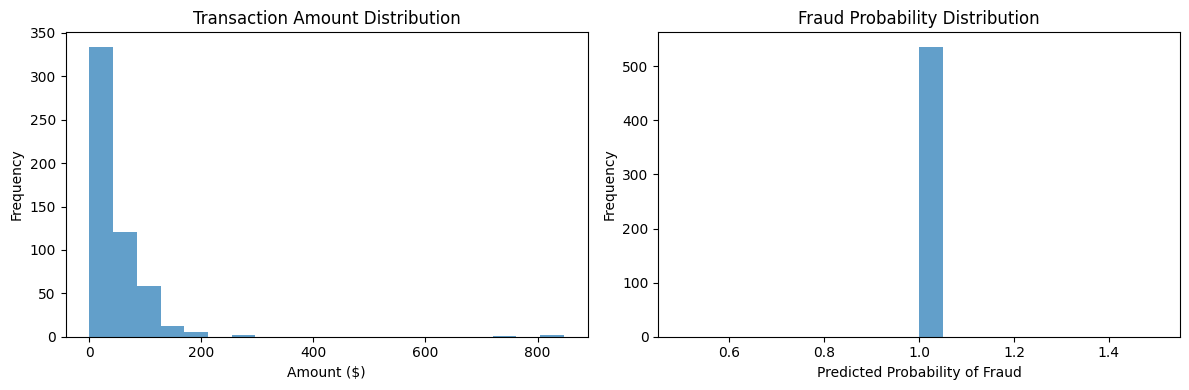

In [14]:
# Simple visualizations - Convert Spark DataFrame to pandas for plotting
sample_fraud = fraud_predictions.sample(0.01, seed=42).toPandas()  # Small sample for visualization
sample_fraud['prob_fraud'] = sample_fraud['probability'].apply(lambda x: float(x[1]))  # Extract fraud probability

plt.figure(figsize=(12, 4))

# Transaction amount distribution
plt.subplot(1, 2, 1)
plt.hist(sample_fraud['amount_numeric'], bins=20, alpha=0.7)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount ($)')
plt.ylabel('Frequency')

# Model's fraud probability distribution
plt.subplot(1, 2, 2)
plt.hist(sample_fraud['prob_fraud'], bins=20, alpha=0.7)
plt.title('Fraud Probability Distribution')
plt.xlabel('Predicted Probability of Fraud')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 3. Basic Time Series Analysis

Time-based patterns in transaction data can reveal business insights and fraud trends.

In [15]:
# Time series feature extraction - Add temporal features for pattern analysis
df_with_time = fraud_data \
    .withColumn("hour", hour(col("date"))) \
    .withColumn("weekday", date_format(col("date"), "EEEE")) \
    .withColumn("is_weekend", dayofweek(col("date")).isin([1, 7]).cast("int"))  # 1=Sunday, 7=Saturday

# Analyze hourly transaction patterns - When do transactions occur?
hourly_patterns = df_with_time.groupBy("hour").agg(
    sum("amount_numeric").alias("hourly_volume"),     # Total transaction volume per hour
    count("*").alias("transaction_count"),            # Number of transactions per hour
    avg("is_fraud").alias("fraud_rate")               # Fraud rate by hour
).orderBy("hour")

print("Hourly transaction patterns:")
hourly_patterns.show(5)

# Compare weekend vs weekday behavior - Business vs leisure patterns
weekend_comparison = df_with_time.groupBy("is_weekend").agg(
    avg("amount_numeric").alias("avg_amount"),        # Average transaction amount
    count("*").alias("transaction_count"),            # Total transactions
    avg("is_fraud").alias("fraud_rate")               # Fraud rate comparison
)

print("Weekend vs Weekday patterns:")
weekend_comparison.show()

Hourly transaction patterns:


25/08/12 02:14:34 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 16.5 MiB so far)
25/08/12 02:14:34 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 32.5 MiB so far)
25/08/12 02:14:34 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 32.4 MiB so far)
25/08/12 02:14:35 WARN MemoryStore: Not enough space to cache rdd_21_8 in memory! (computed 56.4 MiB so far)


+----+------------------+-----------------+-------------------+
|hour|     hourly_volume|transaction_count|         fraud_rate|
+----+------------------+-----------------+-------------------+
|   0| 7848146.799999996|           133365|0.05004311476024444|
|   1| 7325021.480000002|           111847|0.04998792994000733|
|   2|        6202669.05|           109290|0.05040717357489249|
|   3| 6344776.119999993|           101230|0.05056801343475254|
|   4|7100932.6399999885|           111650|0.05071204657411554|
+----+------------------+-----------------+-------------------+
only showing top 5 rows

Weekend vs Weekday patterns:


25/08/12 02:14:35 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 16.5 MiB so far)
25/08/12 02:14:35 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 16.5 MiB so far)
25/08/12 02:14:35 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 32.5 MiB so far)
25/08/12 02:14:36 WARN MemoryStore: Not enough space to cache rdd_21_8 in memory! (computed 56.4 MiB so far)


+----------+------------------+-----------------+------------------+
|is_weekend|        avg_amount|transaction_count|        fraud_rate|
+----------+------------------+-----------------+------------------+
|         1|50.728800302353754|          3610343|0.0501506366569603|
|         0| 50.54981266795212|          9024884|0.0498896163097498|
+----------+------------------+-----------------+------------------+



25/08/12 02:14:37 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 16.5 MiB so far)
25/08/12 02:14:37 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 16.5 MiB so far)
25/08/12 02:14:37 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 32.5 MiB so far)
25/08/12 02:14:37 WARN MemoryStore: Not enough space to cache rdd_21_8 in memory! (computed 56.4 MiB so far)


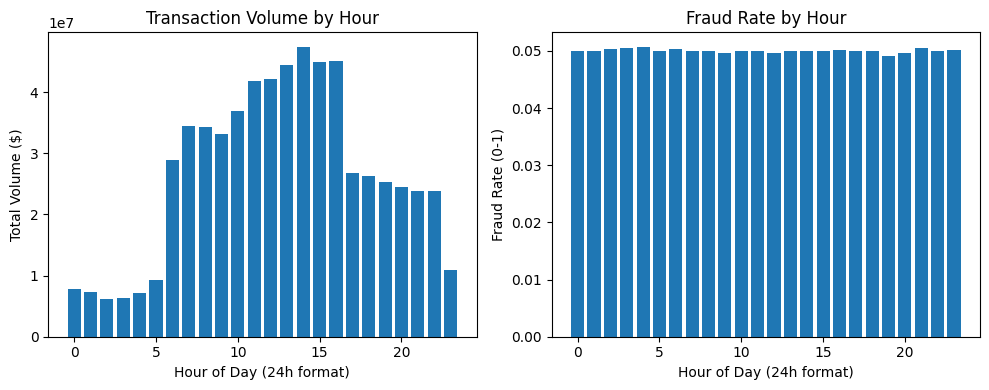

In [16]:
# Time series visualization - Plot temporal patterns
hourly_pd = hourly_patterns.toPandas()  # Convert to pandas for matplotlib

plt.figure(figsize=(10, 4))

# Transaction volume patterns throughout the day
plt.subplot(1, 2, 1)
plt.bar(hourly_pd['hour'], hourly_pd['hourly_volume'])
plt.title('Transaction Volume by Hour')
plt.xlabel('Hour of Day (24h format)')
plt.ylabel('Total Volume ($)')

# Fraud rate patterns - When does fraud peak?
plt.subplot(1, 2, 2)
plt.bar(hourly_pd['hour'], hourly_pd['fraud_rate'])
plt.title('Fraud Rate by Hour')
plt.xlabel('Hour of Day (24h format)')
plt.ylabel('Fraud Rate (0-1)')

plt.tight_layout()
plt.show()

In [6]:
# Simple fraud detection using transaction text
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("FraudDetectionText") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate()

# Transaction descriptions with fraud labels
fraud_text_data = spark.createDataFrame([
    (1, "URGENT ACCOUNT VERIFICATION REQUIRED", 1),  # Fraud
    (2, "WALMART GROCERY PURCHASE", 0),               # Normal
    (3, "SECURITY UPDATE EXPIRES TODAY", 1),          # Fraud
    (4, "STARBUCKS COFFEE SHOP", 0),                  # Normal
    (5, "VERIFY IDENTITY IMMEDIATELY", 1)             # Fraud
], ["id", "description", "is_fraud"])

# Simple text processing pipeline
tokenizer = Tokenizer(inputCol="description", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
count_vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")
fraud_classifier = LogisticRegression(featuresCol="features", labelCol="is_fraud")

# Train fraud detection model
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, fraud_classifier])
fraud_model = pipeline.fit(fraud_text_data)

# Predict fraud from text
predictions = fraud_model.transform(fraud_text_data)
print("Fraud detection results:")
predictions.select("description", "is_fraud", "prediction").show(truncate=False)

# Test model with new unseen transactions
test_data = spark.createDataFrame([
    (6, "CONFIRM DETAILS URGENT ACTION NEEDED", 0),    # Should predict fraud
    (7, "MCDONALDS BREAKFAST ORDER", 0),               # Should predict normal
    (8, "EXPIRES TONIGHT VERIFY NOW", 0),              # Should predict fraud
    (9, "TARGET STORE CLOTHING PURCHASE", 0)           # Should predict normal
], ["id", "description", "is_fraud"])

print("\nTesting model on new transactions:")
test_predictions = fraud_model.transform(test_data)
print("Test predictions:")
test_predictions.select("description", "prediction").show(truncate=False)

spark.stop()  # Stop Spark session when done

Fraud detection results:
+------------------------------------+--------+----------+
|description                         |is_fraud|prediction|
+------------------------------------+--------+----------+
|URGENT ACCOUNT VERIFICATION REQUIRED|1       |1.0       |
|WALMART GROCERY PURCHASE            |0       |0.0       |
|SECURITY UPDATE EXPIRES TODAY       |1       |1.0       |
|STARBUCKS COFFEE SHOP               |0       |0.0       |
|VERIFY IDENTITY IMMEDIATELY         |1       |1.0       |
+------------------------------------+--------+----------+


Testing model on new transactions:
Test predictions:
+------------------------------------+----------+
|description                         |prediction|
+------------------------------------+----------+
|CONFIRM DETAILS URGENT ACTION NEEDED|1.0       |
|MCDONALDS BREAKFAST ORDER           |1.0       |
|EXPIRES TONIGHT VERIFY NOW          |1.0       |
|TARGET STORE CLOTHING PURCHASE      |0.0       |
+------------------------------------+-

# Fraud Detection using Transaction Text Analysis
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create realistic transaction descriptions for fraud detection
transaction_data = spark.createDataFrame([
    (1, "URGENT ACCOUNT VERIFICATION REQUIRED - IMMEDIATE ACTION", 1),  # Fraud
    (2, "SECURITY UPDATE NEEDED NOW - EXPIRES TODAY", 1),               # Fraud  
    (3, "WALMART SUPERCENTER PURCHASE GROCERIES", 0),                   # Legitimate
    (4, "VERIFY IDENTITY PREMIUM SERVICE LIMITED TIME", 1),             # Fraud
    (5, "STARBUCKS COFFEE DOWNTOWN LOCATION", 0),                       # Legitimate
    (6, "AMAZON PRIME MONTHLY SUBSCRIPTION", 0),                        # Legitimate
    (7, "CONFIRM DETAILS URGENT SECURITY BREACH", 1),                   # Fraud
    (8, "SHELL GAS STATION FUEL PURCHASE", 0),                          # Legitimate
    (9, "MCDONALDS DRIVE THRU ORDER", 0),                               # Legitimate
    (10, "IMMEDIATE RESPONSE REQUIRED ACCOUNT SUSPENDED", 1),           # Fraud
    (11, "TARGET STORE HOUSEHOLD ITEMS", 0),                            # Legitimate
    (12, "URGENT VERIFICATION PREMIUM OFFER EXPIRES", 1)                # Fraud
], ["transaction_id", "description", "is_fraud"])

print(f"Transaction fraud dataset: {transaction_data.count()} records")
print("Sample data:")
transaction_data.show(5, truncate=False)

# Text preprocessing pipeline for fraud detection
tokenizer = Tokenizer(inputCol="description", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# TF-IDF for better text feature representation than simple count
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=100)
idf = IDF(inputCol="raw_features", outputCol="features")

# Logistic regression for fraud classification
fraud_classifier = LogisticRegression(featuresCol="features", labelCol="is_fraud")

# Create complete ML pipeline
fraud_pipeline = Pipeline(stages=[tokenizer, stopwords_remover, hashingTF, idf, fraud_classifier])

# Train the fraud detection model
fraud_model = fraud_pipeline.fit(transaction_data)

# Generate predictions with fraud probabilities
predictions = fraud_model.transform(transaction_data)

print("\nFraud Detection Results:")
predictions.select("transaction_id", "description", "is_fraud", "prediction", "probability").show(truncate=False)

In [18]:
# Cleanup - Always stop Spark session to free resources
spark.stop()
print("✅ Spark session terminated cleanly")

✅ Spark session terminated cleanly
